In [28]:
# !pip install zipline-reloaded 
# !pip install seaborn
# !pip install -U scikit-learn scipy
!pip install matplotlib


In [1]:
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np 
import seaborn as sns

# Calendar Imports 
from exchange_calendars.calendar_utils import clear_calendars, get_calendar_names, register_calendar_type, register_calendar
# from exchange_calendars.twentyFourHoursCalenar import twentyFourHourCalendar # CUSTOM CALENDAR
from exchange_calendars.always_open import AlwaysOpenCalendar # CUSTOM CALENDAR
from zipline.utils.calendar_utils import get_calendar

# Bundle Imports 
from zipline.data.bundles import csvdir
from zipline.data.bundles import register
from zipline.data.bundles import ingest
from zipline.data import bundles

# Pipline and Engine Creation 
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders import USEquityPricingLoader
import graphviz

# Intialization Imports 
from zipline.api import order, symbol, record

# Pipline Engine Imports
from zipline.pipeline.domain import EquityCalendarDomain
from zipline.pipeline.data import USEquityPricing, EquityPricing
from zipline.pipeline.factors import SimpleMovingAverage


# DataPortals Imports
from zipline.data.data_portal import DataPortal


#### STEP 1: REGISTER AND GET 24HR CALENDAR 

In [2]:
# LOAD ENV API KEYS 

load_dotenv()
quandl_api_key = os.getenv("QUANDL_API_KEY") # API ACCESS FOR USING QUANDL LIBRARY 

# REGISTER AND GET CUSTOM CALENDAR FOR 24 HOURS TRADING 

# get_calendar_names() #GET REGISTERED CALENDAR NAMES
# clear_calendars()  # CLEAR ALL REGISTERED CALENDERS 
# register_calendar("BTCC", twentyFourHourCalendar, force = True) #REGISTER MY CUSTOM CALENDAR
# register_calendar_type("BTCC", twentyFourHourCalendar, force = True) #REGISTER MY CUSTOM CALENDAR
# get_calendar('BTCC') #GET ME CUSTOM CALENDAR 

register_calendar("24/7", AlwaysOpenCalendar, force = True) #REGISTER 24/7 CALENDAR
register_calendar_type("24/7", AlwaysOpenCalendar, force = True) #REGISTER 24/7 CALENDAR
trading_calendar = get_calendar('24/7') #GET ME 24/7 CALENDAR 

#### STEP 2: REGISTER AND INGEST YOUR BUNDLE

While registering the budle make sure you comply with major requirments 
For instance volume shouldn't exceed specific threshhold

In [3]:
bundle_name = 'my_assets_bundle'
data = csvdir.csvdir_equities(['my_bundle'], '/Users/hosammahmoud/Documents/zipline') # SPECIFY THE DATA DIRECTORY
register(bundle_name, data, calendar_name= "24/7") # REGISTER THE BUDNLE
ingest(bundle_name) # INGEST THE DATA
bundle_data = bundles.load(bundle_name) # LOAD THE BUDNLE

/Users/hosammahmoud/Documents/zipline/myenv/lib/python3.8/site-packages/zipline/data/bcolz_daily_bars.py:341: UserWarning: Ignoring 1 values because they are out of bounds for uint32:
               open    high     low   close  volume
time                                              
2019-11-07  191.16  192.27  184.59  186.68     NaN
  winsorise_uint32(raw_data, invalid_data_behavior, "volume", *OHLC)


In [4]:
# Get a list of all assets
all_assets = bundle_data.asset_finder.retrieve_all(bundle_data.asset_finder.sids)
for asset in all_assets:
    print(asset)

Equity(0 [ADA])
Equity(1 [ATOM])
Equity(2 [AVAX])
Equity(3 [BCH])
Equity(4 [BNB])
Equity(5 [BTC])
Equity(6 [DOGE])
Equity(7 [DOT])
Equity(8 [ETC])
Equity(9 [ETH])
Equity(10 [LINK])
Equity(11 [LTC])
Equity(12 [MATIC])
Equity(13 [SHIB])
Equity(14 [SOL])
Equity(15 [TRX])
Equity(16 [UNI])
Equity(17 [XLM])
Equity(18 [XMR])
Equity(19 [XRP])


#### STEP 3: BUILD AN EMPTY PIPLINE AND RUN THE PIPLINE ENGINE

In [5]:
DOMAIN = EquityCalendarDomain( 'US', '24/7')

# Create a Pipline 
universe = AverageDollarVolume(window_length=120).top(15) 
pipeline = Pipeline(screen = universe, domain = DOMAIN)
pipeline.show_graph() # show the empty screen 


def pricing_loader(bundle_data):
    loader = USEquityPricingLoader.without_fx(
        bundle_data.equity_daily_bar_reader,
        bundle_data.adjustment_reader,
    )

    def get_loader(column):
        return loader
    return get_loader

engine = SimplePipelineEngine(
    get_loader= pricing_loader(bundle_data),
    asset_finder=bundle_data.asset_finder)

start_date = pd.Timestamp('2018-01-04')
end_date = pd.Timestamp('2023-09-05')
output = engine.run_pipeline(pipeline, start_date, end_date)
output.head()

legkwargs 1
kwargs {'country_codes': frozenset({'US'})}


Empty DataFrame
Columns: []
Index: [(2018-04-04 00:00:00, Equity(0 [ADA])), (2018-04-04 00:00:00, Equity(1 [ATOM])), (2018-04-04 00:00:00, Equity(2 [AVAX])), (2018-04-04 00:00:00, Equity(3 [BCH])), (2018-04-04 00:00:00, Equity(4 [BNB]))]

STEP 4: CREATE DATA PORTAL, GET ASSETS AND PRICES

In [6]:
data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

assets = output.index.get_level_values(1).values[0:15].tolist()

price_df = data_portal.get_history_window(
        assets=assets,
        end_dt=end_date,
        bar_count=1000,
        frequency='1d',
        field="close",
        data_frequency='daily')

price_df

,Equity(0 [ADA]),Equity(1 [ATOM]),Equity(2 [AVAX]),Equity(3 [BCH]),Equity(4 [BNB]),Equity(5 [BTC]),Equity(6 [DOGE]),Equity(7 [DOT]),Equity(8 [ETC]),Equity(9 [ETH]),Equity(10 [LINK]),Equity(11 [LTC]),Equity(12 [MATIC]),Equity(13 [SHIB]),Equity(14 [SOL])
2020-12-09,0.148,4.804,3.265,268.70,28.15,18541.28,0.003,4.873,6.063,573.09,12.620,77.41,0.018,NaN,1.659
2020-12-10,0.142,4.655,3.150,265.75,27.69,18254.63,0.003,4.800,5.892,558.99,11.920,74.70,0.018,NaN,1.568
2020-12-11,0.139,4.707,3.237,259.24,27.34,18036.53,0.003,4.612,5.790,544.43,11.630,72.20,0.017,NaN,1.439
2020-12-12,0.144,5.060,3.333,267.89,28.16,18808.69,0.003,4.739,5.971,568.04,12.230,76.67,0.018,NaN,1.491
2020-12-13,0.154,5.195,3.341,276.02,29.16,19174.99,0.003,4.896,6.121,590.70,12.940,82.28,0.018,NaN,1.570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,0.255,6.924,9.980,207.60,216.70,25940.78,0.064,4.271,15.530,1645.76,5.879,63.89,0.550,NaN,19.740
2023-09-01,0.255,6.665,9.920,199.60,213.70,25805.05,0.064,4.218,15.370,1629.12,5.941,62.98,0.540,NaN,19.330
2023-09-02,0.256,6.825,9.920,195.00,214.40,25869.51,0.063,4.261,15.450,1637.03,5.972,64.59,0.541,NaN,19.500
2023-09-03,0.256,6.805,9.880,196.10,214.40,25971.21,0.063,4.259,15.380,1635.84,6.027,63.93,0.542,NaN,19.570


CREATING FACTORS AND FILTERS


In [36]:
import pandas as pd
from zipline.pipeline.factors import SimpleMovingAverage
from zipline.pipeline.factors import DailyReturns

# Create the 30-day average closing price factor
mean_close_30 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=30)

# Create the 60-day average closing price factor
mean_close_60 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=60)

# Create the custom factor
percent_difference = (mean_close_30 - mean_close_60) / mean_close_60

# Create the daily returns factor
daily_ret = DailyReturns(inputs=[USEquityPricing.close])

# Create a filter for the top 20 securities of average dollar volume in a 30 day-window
top_20 = AverageDollarVolume(window_length=30).top(20)

# Create a filter for the latest closing price above $30
above_30 = USEquityPricing.close.latest > 30

# Create a custum filter
tradable_asset = top_20 & above_30

SimpleMovingAverage([EquityPricing<US>.close], 30)

#### FACTOR MODEL OF ASSET/PORTFOLIO RETURNS

The sum of the products of factor exposure times factor return is the contribution of the factors.  It's also called the "common return." 
The specific return is the part of the stock return that isn't explained by the factors.  So it's the actual return minus the common return.  

Ri = Bi * Fi + Si 

Where
- Ri: Asset Returns 
- Bi: Sensitivity to Factor 
- Fi: Factor Return 
- Si: Specific Return

For Portfolio: Portfolio Returns is the sum weighted of Asset Returns sum(xi*Ri)
And the sensitivity of Factors to Portfolio Returns is the sum weighted sensitivity of factor exposures >> sum(Bi)
And the contribution of Factors to Portfolio Returns is the sum weighted of common returns + a specif returns 

Rp = Sum( xi * Bi * Fi) + Sp 

Where
- Rp: portfolio Returns 
- Bi: Sensitivity to Factor 
- Fi: Factor Return 
- xi: Asset weight in Portfolio
- Sp: Specific Return of Portfolio


Asset  -  Sensitivity to Factors
Equity(0 [ADA]) [0.47353259 0.49562576]
Equity(1 [ATOM]) [0.61413265 0.46961353]
Equity(2 [AVAX]) [1.00511883 0.10547432]
Equity(3 [BCH]) [0.37977363 0.61984367]
Equity(4 [BNB]) [0.37283205 0.51717558]
Equity(5 [BTC]) [-0.00285391  0.68179401]
Equity(6 [DOGE]) [ 8.14756219 -7.40474493]
Equity(7 [DOT]) [0.29535093 0.80074944]
Equity(8 [ETC]) [0.92048813 0.14091855]
Equity(9 [ETH]) [-0.06217397  1.01056637]
Equity(10 [LINK]) [0.24754212 0.86813465]
Equity(11 [LTC]) [0.1390807  0.86120533]
Equity(12 [MATIC]) [0.66735455 0.59803544]
Equity(14 [SOL]) [0.80225951 0.2356083 ]


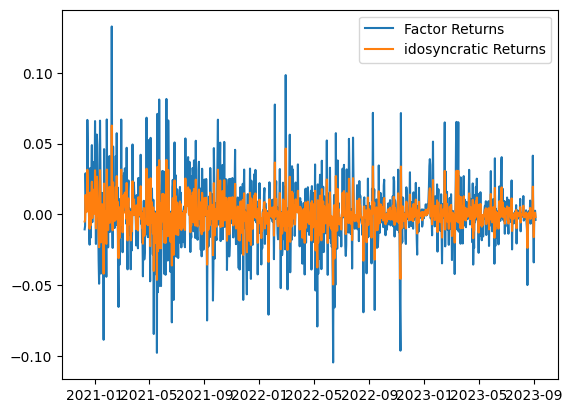

In [35]:
factor_return_1 = returns_df.mean(axis=1) #GET MEAN
factor_return_2 = returns_df.median(axis=1) #GET MEDIAN
factor_return_l = [factor_return_1, factor_return_2]

from sklearn.linear_model import LinearRegression

"""
For now, We just assume that we're calculating a number for each 
asset, for each factor, which represents how "exposed" each asset is
to each factor. 
"""
def get_factor_exposures(factor_return_l, asset_return):
    lr = LinearRegression()
    X = np.array(factor_return_l).T
    y = np.array(asset_return.values)
    lr.fit(X,y)
    return lr.coef_

lr = LinearRegression()
X = np.array([factor_return_1.values,factor_return_2.values]).T
y = np.array(returns_df.values)
lr.fit(X,y)


#CONTRIBUTION OF RET

print('Asset'," - " , 'Sensitivity to Factors')
for i in range(0,14): 
    factor_exposure = lr.coef_[i] #Exposure of Asset Factor to Returns 
    print(returns_df.columns[i], factor_exposure)
    

factor_exposures_returns_btc =  lr.coef_[5][0]
factor_exposures_median_btc =  lr.coef_[5][1]

btc_return_discribed_by_factors =  factor_exposures_returns_btc* returns_df[returns_df.columns[5]] \
                                    + factor_exposures_median_btc* returns_df[returns_df.columns[5]]
btc_returns_undiscribed = returns_df[returns_df.columns[5]] - btc_return_discribed_by_factors

import matplotlib.pyplot as plt 

plt.plot(btc_return_discribed_by_factors, label = 'Factor Returns')
plt.plot(btc_returns_undiscribed, label = 'idosyncratic Returns')
plt.legend()

#### FACTOR MODEL OF ASSET/PORTFOLIO RETURNS

$\textrm{Var}(f_{1}) = \beta_{1,1}^2 \textrm{Var}(f_{1}) + \beta_{1,2}^2 \textrm{Var}(f_{2}) + 2\beta_{1,1}\beta_{1,2}\textrm{Cov}(f_{1},f_{2}) + \textrm{Var}(s_{1})$

Where 
- VAR(Ri): Variance of Asset i
- Bi: Sensitivity of Asset to each Factors  
- F: Factors  (0-N)
- VAR(Si): Specific Variance for Asset i 


Variance Of Portfolio 

VAR(Rp) = XT * (B F BT + S)* X

Where 
- X: Weight Matrix 
- B: Sensitivity Matrix 
- F: Factors Matrix 
- S: Specific Variance Matrix 

portfolio variance is 
0.00201891


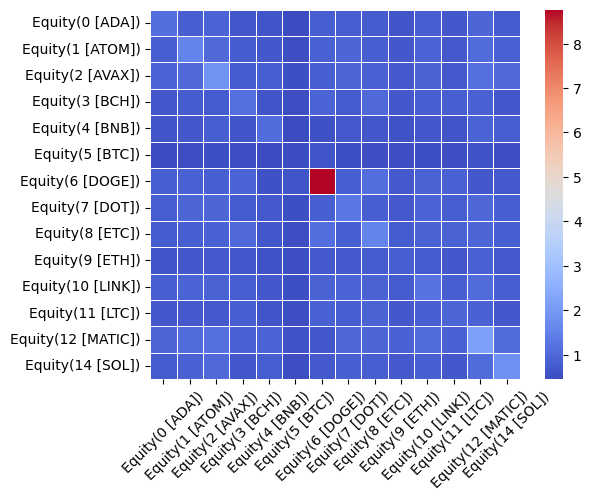

In [46]:
returns_df = price_df.pct_change().tail(-1).drop(price_df.columns[-2], axis=1)
covariance_assets =  np.cov(returns_df.T) * 365 # annualization_factor 

asset_names = returns_df.columns
heatmap = sns.heatmap(covariance_assets,   fmt=".1f",  cmap="coolwarm", 
                        cbar=True,   square=True,  linewidths=0.5)  
heatmap.set_xticklabels(asset_names, rotation=45, fontsize=10)
heatmap.set_yticklabels(asset_names, rotation=0, fontsize=10)


# From Our Linear Regression Append all factor sensitivities in one place
factor_exposure_f = []
for i in range(0,14): 
    factor_exposure_f.append(lr.coef_[i]) #Exposure of Asset Factor to Returns 
    
B = np.array(factor_exposure_f) # Exposure Metrics 
X = np.array([1/15 for i in range(0,14)]).reshape(14,1) # Portfolio Weights - Assume Equal 
F = np.cov(factor_return_1, factor_return_2,ddof=1) 
S = 0 #Ignore Idysncoratic Variace for now 

var_portfolio = X.T.dot(B.dot(F).dot(B.T)).dot(X)
print(f"portfolio variance is \n{var_portfolio[0][0]:.8f}")


PREFORM TRANSACTIONS AND IMPLEMENT YOUR STRATEGY 

In [ ]:
def initialize(context):
    pass


def handle_data(context, data):
    order(symbol('ADA'), 10) #Buy command - how many shares of APPLE 
    record(ADA=data.current(symbol('AAPL'), 'price')) #Record this in some sort of potfolio I guess